In [1]:
%matplotlib inline
!nvidia-smi

Thu Nov 24 17:46:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt

In [3]:
torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(4).type(torch.int64), value=1)

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [4]:
class Normalize(object):
    def __init__(self) -> None:
        super().__init__()

    def __call__(self, image):
        return (image - image.min())/(image.max() - image.min())

In [5]:
class FashionMNISTSet:
    def __init__(self, dim=(28,28), batch_size=32) -> None:
        composition = transforms.Compose([
            transforms.Resize(dim), 
            transforms.ToTensor(),
            Normalize()
        ])
        # label_transform = transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y).type(torch.int64), value=1))
        self.train_set = FashionMNIST(root='./dataset', train=True, download=True, transform=composition)
        self.val_set = FashionMNIST(root='./dataset', train=False, download=True, transform=composition)
        self.batch_size = batch_size
        self.dim = dim
        
    def create_dataloader(self, train: bool):
        """Create a dataloader."""
        if train:
            shuffle = True
            dataset = self.train_set
        else:
            shuffle = False
            dataset = self.val_set
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)
    
    def text_labels(self, indices):
        """Return text labels."""
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(torch.argmax(i).item())] for i in indices]
    
    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)

        _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,8))
        
        for i, ax in enumerate(axes.flat):
            ax.imshow(X[i].squeeze(0), cmap='gray')
            ax.set_title(labels[i])
            ax.axis('off')

In [6]:
data = FashionMNISTSet()
len(data.train_set), len(data.val_set)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



(60000, 10000)

In [7]:
im1, label1 = data.train_set[0]

In [8]:
im1.shape, label1

(torch.Size([1, 28, 28]), 9)

In [9]:
batch_test = next(iter(data.create_dataloader(train=True)))

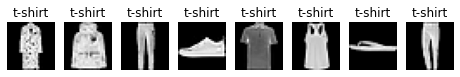

In [10]:
data.visualize(batch_test)

In [11]:
def softmax(x):
    X_exp = torch.exp(x)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

In [12]:
class Classification(torch.nn.Module):
    def __init__(self, num_in: int, num_out: int, lr=0.01, sigma=0.01) -> None:   
        super().__init__()
        
        # define model
        self.W = torch.normal(0, sigma, size=(num_in, num_out), requires_grad=True)
        self.b = torch.zeros(num_out, requires_grad=True)
    
        self.lr = lr
        self.plots = {}
    
    def parameters(self):
        return [self.W, self.b]

    def forward(self, X):
        return softmax(torch.matmul(
            torch.reshape(X, (-1, self.W.shape[0])), self.W
        ) + self.b)

    def configure_optimizer(self):
        self.opt = torch.optim.SGD(self.parameters(), lr=self.lr)
    
    def loss(self, yhat, y):
        # out = -torch.log(yhat[:, y]).mean()
        # if np.isnan(out.detach().numpy()):
        #     print('nan found:', out)
        # return out
        loss_fn = torch.nn.CrossEntropyLoss()
        print('Pred/targ: ', yhat, y)
        return loss_fn(yhat, y)
    
    def accuracy(self, y_hat, y):
        return (y_hat.argmax(1) == y).float().mean()
    
    def train_step(self, batch):
        self.opt.zero_grad()
        X, y = batch
        y_hat = self(X)
        loss = self.loss(y_hat, y)
        if not np.isnan(loss.detach().numpy()):
            loss.backward()
            self.opt.step()
            return loss.item()
        else:
            print(y_hat, y)
            return 1e-6
    
    def val_step(self, batch):
        X, y = batch
        y_hat = self(X)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        return loss.item()
        
    def plot(self, title: str, val: float):
        if title not in self.plots.keys():
            self.plots[title] = []
        self.plots[title].append(val)

In [13]:
X = torch.randn(2, 5)
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.8018, 0.0618, 0.0201, 0.0535, 0.0627],
         [0.1598, 0.3806, 0.3541, 0.0345, 0.0710]]), tensor([1.0000, 1.0000]))

In [14]:
data = FashionMNISTSet(dim=(28,28), batch_size=256)
model = Classification(28*28, 10, lr=0.01, sigma=0.01)
model.configure_optimizer()

train_loader = data.create_dataloader(train=True)
val_loader = data.create_dataloader(train=False)

In [15]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [16]:
model.loss(y_hat, y)

Pred/targ:  tensor([[0.1000, 0.3000, 0.6000],
        [0.3000, 0.2000, 0.5000]]) tensor([0, 2])


tensor(1.1466)

In [ ]:
# torch.autograd.set_detect_anomaly(True)
epochs = 10

for epoch in range(epochs):
    tr_loss = val_loss = 0
    for batch in train_loader:
        tr_loss += model.train_step(batch)
    # for batch in val_loader:
    #     val_loss += model.val_step(batch)
    
    tr_loss /= len(train_loader)
    # val_loss /= len(val_loader)

    model.plot('train_loss', tr_loss)
    # model.plot('val_loss', val_loss)

    print('epoch %d, train loss %.4f' % (epoch, tr_loss))

In [18]:
print(model.plots)

{'train_loss': [1.8889527670880581, 0.31120558920817076, 0.03801581168673894, 0.015189125966855252, 0.015008297649172476, 0.007449066351967591, 0.007748379065266029, 9.999999999999976e-07, 9.999999999999976e-07, 0.022739239021593537]}


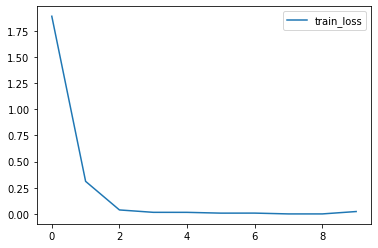

In [19]:
for key, val in model.plots.items():
    plt.plot(val, label=key)
plt.legend()